In [1]:
%%capture
%matplotlib inline
from functools import partial
import matplotlib.pyplot as plt
import math
try:
    import optax
except ModuleNotFoundError:
    %pip install -qq optax
    import optax
import jax
import jax.numpy as jnp
from jax import jit
from jax.nn.initializers import glorot_normal
try:
    import flax
except ModuleNotFoundError:
    %pip install -qq flax
    import flax
import flax.linen as nn
from flax.training import train_state
import tensorflow_probability.substrates.jax as tfp
from typing import Any, Callable, Sequence, Optional

In [2]:
# def loss_single_point(params, x, y):
#     dist = tfp.distributions
#     mu, log_sigma = model.apply(params, x)
#     sigma = jnp.exp(log_sigma)
#     d = dist.Normal(loc=mu, scale=sigma)
#     return -d.log_prob(y)
def NLL(params,x,y):
    mean,var = model.apply(params,x)
    return (jnp.log(var) /2+ (((y - mean)**2)/var)/2+jnp.log(6.28)/2).sum()
def loss_batch(params):
    return jnp.mean(
        jax.vmap(NLL, in_axes=(None, 0, 0))(params, X.reshape(-1, 1), Y)
    )
def defineX(key, x,noise=True):
    epsilons = jax.random.normal(key, shape=(3,)) * 0.5
    return (
        3*x*x+ x*epsilons[1]  #For Polynomial 
    )
# def mse(params, x_batched, y_batched):
#   def squared_error(x, y):
#     pred = model.apply(params, x)
#     return jnp.inner(y-pred, y-pred) / 2.0
#   return jnp.mean(jax.vmap(squared_error)(x_batched,y_batched), axis=0)
class MLP(nn.Module):
    architecture: Sequence[int]
    @nn.compact
    def __call__(self, x):
        for i, n_neurons in enumerate(self.architecture):
          x = nn.Dense(n_neurons, name=f'layers_{i}')(x)
          if i != len(self.architecture) - 1:
            x = nn.relu(x)

        x = x.at[1].set(jnp.log(1+jnp.exp(x[1])))
        return x

In [3]:
key, subkey = jax.random.split(jax.random.PRNGKey(0))
X = jax.random.uniform(key, shape=(500, 1), minval=-1, maxval=1)
X_test_1 = jnp.linspace(-1, -1.5 ,500).reshape(-1, 1)
X_test_2 = jnp.linspace(1,1.5, 500).reshape(-1, 1)
target_vmap = jax.vmap(defineX, in_axes=(0, 0), out_axes=0)
keys = jax.random.split(subkey, X.shape[0])
Y_without_noise =3*jnp.sort(X[:,0])*jnp.sort(X[:,0])
Y = target_vmap(keys, X)
Y_test_1 = target_vmap(keys, X_test_1)
Y_test_2 = target_vmap(keys, X_test_2)

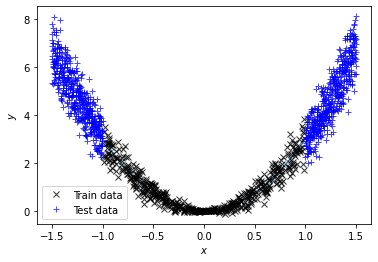

In [4]:
plt.figure() 
plt.plot(jnp.sort(X[:,0]),Y_without_noise)
plt.plot(X, Y, "kx", label="Train data", alpha=0.8)
plt.plot(X_test_1, Y_test_1, "b+", label="Test data", alpha=0.7)
plt.plot(X_test_2, Y_test_2, "b+", alpha=0.7)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.show()

In [5]:

model = MLP([16,64,2]) 
key1, key2 = jax.random.split(jax.random.PRNGKey(23))
init_var= jax.random.normal(key1, (1,))
params = model.init(key2, init_var) 

In [6]:
LEARNING_RATE = 0.01
for i in range(200):
    if i % 20 == 0:
        print(i, loss_batch(params))
    grads = jax.grad(loss_batch)(params)
    params = jax.tree_map(lambda p, g: p - LEARNING_RATE * g, params, grads)

0 1.7659513
20 1.137792
40 1.0134603
60 0.9412625
80 0.87489223
100 0.8091805
120 0.7460009
140 0.6874429
160 0.635247
180 0.5903782


In [7]:
Y_pred_1 = model.apply(params,X_test_1)
Y_pred = model.apply(params,X)
Y_pred_2 = model.apply(params,X_test_2)

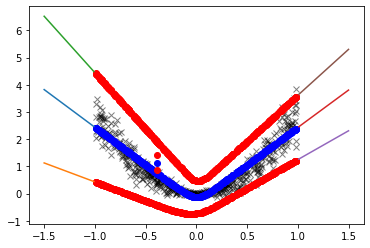

In [8]:
#Hetero
plt.plot(X,Y,'kx',alpha=0.5)
plt.plot(X,Y_pred[:,0],'bo')
# plt.plot(X,Y_without_noise,color='black')
plt.plot(X,Y_pred[:,0]-Y_pred[:,1],'ro')
plt.plot(X,Y_pred[:,0]+Y_pred[:,1],'ro')
# plt.fill_between(X.reshape(500),Y_pred[:,0]+Y_pred[:,1],Y_pred[:,0]-Y_pred[:,1],alpha=0.5)
plt.plot(X_test_1[10:],Y_pred_1[10:,0])
plt.plot(X_test_1[10:],Y_pred_1[10:,0]+Y_pred_1[10:,1])
plt.plot(X_test_1[10:],Y_pred_1[10:,0]-Y_pred_1[10:,1])
plt.plot(X_test_2[10:],Y_pred_2[10:,0])
plt.plot(X_test_2[10:],Y_pred_2[10:,0]+Y_pred_2[10:,1])
plt.plot(X_test_2[10:],Y_pred_2[10:,0]-Y_pred_2[10:,1])
# plt.plot(X_test_1,model.apply(params,X_test_1),'bx')
# plt.plot(X_test_2,model.apply(params,X_test_2),'bx')
# plt.ylim([-2,4])